# Random Forest
The nature of our models'
 training, testing, and evaluation is that the data is split into training, testing, and validation sets. 
 
2014-2022 will be used as training and testing while 2023-2024 will be used for validation.
 
## Number of models
The models to be made are:
- 1 week ahead
- 2 weeks ahead
- 3 weeks ahead
- 4 weeks ahead
- 12 weeks ahead

Two main types of model will be made:
- Municipal Level
- Provincial Level

There are 42 municipals in the province + 1 main city, Iloilo City. Hence, there will be 10x43 = 430 Local Models and 1x5 = 5 Provincial Model, making a total of 435 models.

Each n-week ahead model will have the same hyperparameters for different municipalities to avoid having too many models and avoiding unnecessary complexity.


## 10-Fold Cross Validation
The training and testing data will be used for the 10-Fold Cross Validation.

## Utilities
Functions that serve as utilities for the models will be made in a separate file. These functions will be used to:
- Save the predicted and actual observations to a CSV file.
- save the evaluation reports to a CSV file.


In [2]:
# import necessary modules
import pandas as pd
import sys
import warnings
warnings.filterwarnings("ignore")
sys.path.append('..')
import models_utils
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Cross Validation with GridSearchCV
To find the optimal hyperparameter of the Random Forest model, a GridSearchCV will be used with a cv=10.
Since 

In [2]:
def get_best_hyperparameters(df, n_week_ahead, features=["Temperature", "Humidity", "Precipitation"], target="Cases", date_col="Year-Week", pooled=False):
    """
    Function to get the best hyperparameters for the Random Forest model using GridSearchCV.
    """
    # Create a Random Forest Regressor
    if not pooled:
        # If pooled, we need to use the pooled data
        data = models_utils.prepare_dataframe(df,["Temperature", "Humidity", "Precipitation"], ["Year", "Week", "Month", "Population"],"Cases", "Year-Week", n_week_ahead)
    else:
        data = df
    X_train = data.drop(columns=['Cases', 'Year-Week'])
    y_train = data['Cases']
    rf = RandomForestRegressor()

    # Create a parameter grid to search
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [5, 10, 15],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
    }

    # Create a GridSearchCV object
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=10, n_jobs=-1)

    # Fit the GridSearchCV object to the training data
    grid_search.fit(X_train, y_train)

    # Get the best hyperparameters
    best_hyperparameters = grid_search.best_params_

    return best_hyperparameters

In [3]:
municipals = []
with (open("../municipals.txt", "r") as f):
    for line in f:
        municipals.append(line.strip())
municipals

['Ajuy',
 'Alimodian',
 'Anilao',
 'Badiangan',
 'Balasan',
 'Banate',
 'Barotac Nuevo',
 'Barotac Viejo',
 'Batad',
 'Bingawan',
 'Cabatuan',
 'Calinog',
 'Carles',
 'Passi City',
 'Concepcion',
 'Dingle',
 'Duenas',
 'Dumangas',
 'Estancia',
 'Guimbal',
 'Iloilo City',
 'Igbaras',
 'Janiuay',
 'Lambunao',
 'Leganes',
 'Lemery',
 'Leon',
 'Maasin',
 'Miagao',
 'Mina',
 'New Lucena',
 'Oton',
 'Pavia',
 'Pototan',
 'San Dionisio',
 'San Enrique',
 'San Joaquin',
 'San Miguel',
 'San Rafael',
 'Santa Barbara',
 'Sara',
 'Tigbauan',
 'Tubungan',
 'Zarraga']

## For Municipal Level

In [4]:
best_parameters = []
n_weeks_ahead = [1,2,3,4,8,12]
for n in n_weeks_ahead:
    for municipal in municipals:
        municipal_df = pd.read_csv(f"../../data/Merged Data/{municipal}_merged.csv")
        best_params_model = get_best_hyperparameters(df = municipal_df, n_week_ahead=n)
        best_parameters.append({
            "Municipal": municipal,
            "Weeks Ahead": n,
            "Best Hyperparameters": best_params_model
        })


KeyboardInterrupt: 

In [11]:
# Checking the count of best hyperparameters
# Checking the count of best hyperparameters
best_parameters_count = {}
for param in best_parameters:
    # Convert the dictionary of hyperparameters to a tuple of sorted key-value pairs
    hyperparameters_tuple = tuple(sorted(param["Best Hyperparameters"].items()))
    if hyperparameters_tuple not in best_parameters_count:
        best_parameters_count[hyperparameters_tuple] = 1
    else:
        best_parameters_count[hyperparameters_tuple] += 1

In [12]:
#check top 3 best hyperparameters
sorted(best_parameters_count.items(), key=lambda x: x[1], reverse=True)[:3]

[((('max_depth', 5),
   ('min_samples_leaf', 2),
   ('min_samples_split', 2),
   ('n_estimators', 100)),
  39),
 ((('max_depth', 5),
   ('min_samples_leaf', 2),
   ('min_samples_split', 2),
   ('n_estimators', 200)),
  34),
 ((('max_depth', 5),
   ('min_samples_leaf', 2),
   ('min_samples_split', 5),
   ('n_estimators', 200)),
  32)]

<BarContainer object of 20 artists>

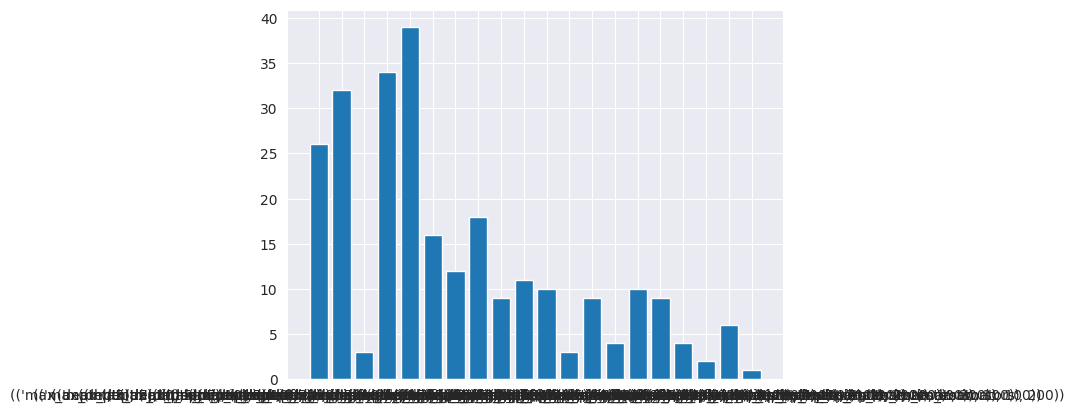

In [42]:
import matplotlib.pyplot as plt
plt.bar([str(x) for x in list(best_parameters_count.keys())], best_parameters_count.values())

In [30]:
# save best hyperparameters to a csv file
municipal = []
weeks_ahead = []
max_depth = []
min_samples_split = []
min_samples_leaf = []
n_estimators = []
for model in best_parameters:
    print(model)
    print(model["Municipal"])
    municipal.append(model["Municipal"])
    weeks_ahead.append(model["Weeks Ahead"])
    max_depth.append(model["Best Hyperparameters"]["max_depth"])
    min_samples_split.append(model["Best Hyperparameters"]["min_samples_split"])
    min_samples_leaf.append(model["Best Hyperparameters"]["min_samples_leaf"])
    n_estimators.append(model["Best Hyperparameters"]["n_estimators"])

print(len(max_depth))
best_parameters_df = pd.DataFrame({
    "Municipal": municipal,
    "Weeks Ahead": weeks_ahead,
    "max_depth": max_depth,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf,
    "n_estimators": n_estimators
})
best_parameters_df.to_csv("best_hyperparameters.csv", index=False)

0


In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import numpy as np

def train_RF(data, features_lag, features_addtl, target, date_col, n_ahead, year_test_start, year_test_end):
    # Select relevant columns
    rel_col = features_lag + features_addtl + [target] + [date_col]
    data = data[rel_col]
    data[date_col] = pd.to_datetime(data[date_col])

    # Define lags
    env_lags = [1, 2, 3, 4]
    cases_lag = range(n_ahead, n_ahead+12)

    # Create lagged features for environment and target variables
    for lag in env_lags:
        for feature in features_lag:
            data[f'{feature}_lag_{lag}'] = data[feature].shift(lag)

    for lag in cases_lag:
        data[f'{target}_lag_{lag}'] = data[target].shift(lag)

    # Remove any rows with missing values due to lagging
    data = data.dropna()

    # Split data into training and testing sets
    if year_test_end == "2024-12-31":
        train_data = data[data[date_col] < year_test_start]
    else:
        train_data = data[(data[date_col] < year_test_start) | (data[date_col] >= year_test_end)]
    test_data = data[(data[date_col] >= year_test_start) & (data[date_col] < year_test_end)]

    X_train = train_data.drop(columns=[target, date_col])
    y_train = train_data[target]
    X_test = test_data.drop(columns=[target, date_col])
    y_test = test_data[target]

    # Initialize and train the Random Forest model
    rf_model = RandomForestRegressor(
        n_estimators=100,
        max_depth=5,
        min_samples_leaf=2,
        min_samples_split=2,
        n_jobs=-1
    )
    rf_model.fit(X_train, y_train)

    # Predict on test data
    predict_data = rf_model.predict(X_test)
    actual_data = y_test.values

    # Make predictions integer
    predict_data = [int(round(x)) for x in predict_data]

    # Calculate Mean Absolute Error and Mean Squared Error
    MAE = mean_absolute_error(actual_data, predict_data)
    MSE = mean_squared_error(actual_data, predict_data)
    # get feature importance in a dictionary
    feature_importance = rf_model.feature_importances_
    feature_importance_dict = {}
    for i, feature in enumerate(X_train.columns):
        feature_importance_dict[feature] = feature_importance[i]
    return predict_data, MAE, MSE, feature_importance_dict


In [4]:
municipals = []
with (open("../municipals.txt", "r") as f):
    for line in f:
        municipals.append(line.strip())

KeyboardInterrupt: 

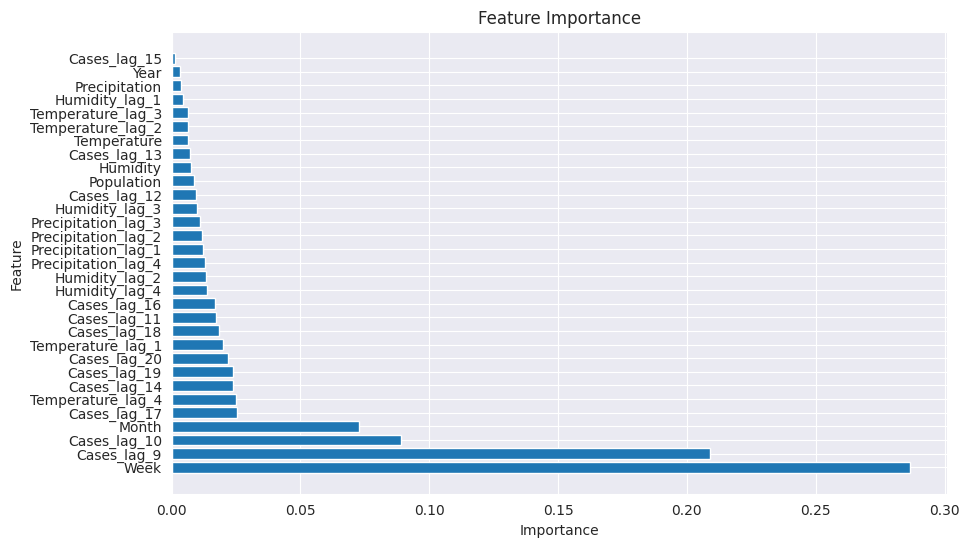

In [27]:
import sys
sys.path.append('..')
import models_utils
n_weeks_ahead = [1,2,3,4,5,6,7,8,9,10,11,12]
for municipal in municipals:
    for n in n_weeks_ahead:
        municipal_df = pd.read_csv(f"../../data/Merged Data/{municipal}_merged.csv")
        municipal_df["Year-Week"] = pd.to_datetime(municipal_df["Year-Week"])
        predicted, MAE, MSE, feature_importance_dict = train_RF(municipal_df, features_lag=["Temperature", "Precipitation", "Humidity"], features_addtl = ["Year", "Month", "Week", "Population"], target="Cases", date_col="Year-Week", n_ahead=n, year_test_start="2023-01-01", year_test_end="2024-12-31")
        models_utils.save_data(municipal, n, MSE, MAE, predicted, municipal_df, type = "Municipal")
        models_utils.save_feat_imp(municipal, n, feature_importance_dict, type = "Municipal")

# Pooled Provincial Model

The pooled provincial model means taking all the data from the municipalities and training a single model on it. 

This is done to see if the model can generalize well across all municipalities.

Hence, we have 43x11x52 = 24596 rows of data.

# Lagging Methods
The method for lagging the data is somewhat different for this. First, we must lag the data for each municipal, then we can pool the data together.

In [26]:
import sys
sys.path.append('..')
import models_utils
import pandas as pd
import matplotlib.pyplot as plt


In [4]:
municipals = []
with (open("../municipals.txt", "r") as f):
    for line in f:
        municipals.append(line.strip())

In [41]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
def get_best_hyperparameters_pooled(n_weeks_ahead, features=["Temperature", "Humidity", "Precipitation"], target="Cases", date_col="Year-Week"):
    """
    Function to get the best hyperparameters for the Random Forest model using GridSearchCV.
    """
    # Create a Random Forest Regressor
    pooled_df = pd.DataFrame()
    for municipal in municipals:
        municipal_df = pd.read_csv(f"../../data/Merged Data/{municipal}_merged.csv")
        municipal_df["Municipal"] = municipal
        # lag the features
        municipal_df = models_utils.prepare_dataframe(municipal_df, ["Temperature", "Precipitation", "Humidity"], ["Year", "Week", "Month", "Population"], "Cases", "Year-Week", n_weeks_ahead)
        pooled_df = pd.concat([pooled_df, municipal_df], axis=0)
    data = pooled_df
    X_train = data.drop(columns=['Cases', 'Year-Week'])
    y_train = data['Cases']
    rf = RandomForestRegressor()

    # Create a parameter grid to search
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [5, 10, 15],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
    }

    # Create a GridSearchCV object
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=10, n_jobs=-1)

    # Fit the GridSearchCV object to the training data
    grid_search.fit(X_train, y_train)

    # Get the best hyperparameters
    best_hyperparameters = grid_search.best_params_

    return best_hyperparameters

In [42]:
# Making a pooled dataset
best_hyperparameters_pooled_1 = get_best_hyperparameters_pooled(1)
best_hyperparameters_pooled_2 = get_best_hyperparameters_pooled(2)
best_hyperparameters_pooled_3 = get_best_hyperparameters_pooled(3)
best_hyperparameters_pooled_4 = get_best_hyperparameters_pooled(4)
best_hyperparameters_pooled_8 = get_best_hyperparameters_pooled(8)
best_hyperparameters_pooled_12 = get_best_hyperparameters_pooled(12)




/home/miniloda/Documents/GitHub/Math-198.1---Special-Problem/venv/lib/python3.10/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


KeyboardInterrupt: 

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

def train_RF_provincial(X_train, y_train, hyperparameters: dict):

    # Initialize and train the Random Forest model
    rf_model = RandomForestRegressor(
        n_estimators=hyperparameters["n_estimators"],
        max_depth=hyperparameters['max_depth'],
        min_samples_leaf=hyperparameters['min_samples_leaf'],
        min_samples_split=hyperparameters['min_samples_split'],
        n_jobs=-1
    )
    rf_model.fit(X_train, y_train)
    return rf_model

def test_RF_provincial(model, X_test, y_test):
    # Predict on test data
    predict_data = model.predict(X_test)
    actual_data = y_test.values

    # Make predictions integer
    predict_data = [int(round(x)) for x in predict_data]

    # Calculate Mean Absolute Error and Mean Squared Error
    MAE = mean_absolute_error(actual_data, predict_data)
    MSE = mean_squared_error(actual_data, predict_data)
    # get feature importance in a dictionary
    feature_importance = model.feature_importances_
    feature_importance_dict = {}
    for i, feature in enumerate(X_test.columns):
        feature_importance_dict[feature] = feature_importance[i]
        
    return predict_data, MAE, MSE, feature_importance_dict

In [14]:
n_weeks_ahead = [1,2,3,4,5,6,7,8,9,10,11,12]
import warnings
warnings.filterwarnings("ignore")
for n in n_weeks_ahead:

    pooled_df = pd.DataFrame()
    for municipal in municipals:
        municipal_df = pd.read_csv(f"../../data/Merged Data/{municipal}_merged.csv")
        municipal_df["Municipal"] = municipal
        # lag the features
        municipal_df = models_utils.prepare_dataframe(municipal_df, ["Temperature", "Precipitation", "Humidity"], ["Year", "Week", "Month", "Population"], "Cases", "Year-Week", n)
        pooled_df = pd.concat([pooled_df, municipal_df], axis=0)
    
    pooled_df.dropna()
    pooled_X = pooled_df.drop(columns=["Cases", "Year-Week"])
    pooled_y = pooled_df["Cases"]
    pooled_X_train = pooled_X[pooled_df["Year-Week"] < "2023-01-01"]
    pooled_y_train = pooled_y[pooled_df["Year-Week"] < "2023-01-01"]
    model = train_RF_provincial(pooled_X_train, pooled_y_train, {'max_depth': 15,
                                                                 'min_samples_leaf': 2,
                                                                 'min_samples_split': 2,
                                                                 'n_estimators': 100})
    for municipal in municipals:
        municipal_df = pd.read_csv(f"../../data/Merged Data/{municipal}_merged.csv")
        municipal_df["Year-Week"] = pd.to_datetime(municipal_df["Year-Week"])
        municipal_df = models_utils.prepare_dataframe(municipal_df, ["Temperature", "Precipitation", "Humidity"], ["Year", "Week", "Month", "Population"], "Cases", "Year-Week", n)
        municipal_X = municipal_df.drop(columns=["Cases", "Year-Week"])
        municipal_y = municipal_df["Cases"]
        municipal_X_test = municipal_X[(municipal_df["Year-Week"] >= "2023-01-01") & (municipal_df["Year-Week"] < "2024-12-31")]
        municipal_y_test = municipal_y[(municipal_df["Year-Week"] >= "2023-01-01") & (municipal_df["Year-Week"] < "2024-12-31")]
        predicted, MAE, MSE, feature_importance_dict = test_RF_provincial(model, municipal_X_test, municipal_y_test)
        models_utils.save_data(municipal, n, MSE, MAE, predicted, municipal_df, type = "Provincial")
    print(n)
        


1
2
3
4
5
6
7
8
9
10
11
12


In [22]:
model = train_RF_provincial(pooled_X_train, pooled_y_train, {'max_depth': 15,
                                                             'min_samples_leaf': 2,
                                                             'min_samples_split': 2,
                                                             'n_estimators': 100})
predicted, MAE, MSE, feature_importance_dict = test_RF_provincial(model, Ajuy_X_test, Ajuy_y_test)

In [23]:
MAE

np.float64(8.266666666666667)

In [24]:
MSE

np.float64(264.55238095238093)

Text(0.5, 1.0, 'Predicted vs Actual for Iloilo City')

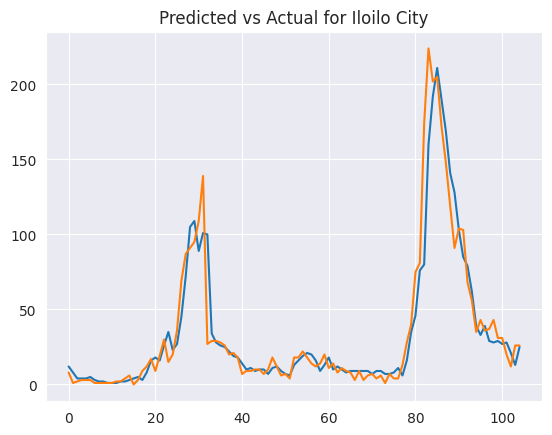

In [27]:
plt.plot(predicted, label="Predicted")
plt.plot(Ajuy_y_test.values, label="Actual")
plt.title("Predicted vs Actual for Iloilo City")

# Summed Provincial Model

## Table for Features and Cases recalculated

| Population | Temperature | Humidity | Precipitation | Cases |
|------------|-------------|----------|---------------|-------|
| Mean       | Median      | Median   | Median        | Sum   |

Year, Month, and Week will remain as is



In [5]:
import sys
sys.path.append('..')
import models_utils
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
municipals = []
with (open("../municipals.txt", "r") as f):
    for line in f:
        municipals.append(line.strip())

In [7]:
summed_df_list = []
for municipal in municipals:
    municipal_df = pd.read_csv(f"../../data/Merged Data/{municipal}_merged.csv")
    # lag the features
    municipal_df = models_utils.prepare_dataframe(municipal_df, ["Temperature", "Precipitation", "Humidity"], ["Year", "Week", "Month", "Population"], "Cases", "Year-Week", 1)
    summed_df_list.append(municipal_df)

In [8]:
summed_df = models_utils.prepare_dataframe_summed(summed_df_list)
summed_df.head()

,Year-Week,Temperature,Humidity,Precipitation,Cases,Population,Year,Month,Week
0,2014-03-24,27.338571,72.048598,31.200000,21.0,53490.25,2014,3,13
1,2014-03-31,28.420321,76.866595,25.500000,18.0,53490.25,2014,3,14
2,2014-04-07,29.111821,69.364982,2.800000,11.0,53490.25,2014,4,15
3,2014-04-14,28.551928,71.990313,30.800000,16.0,53490.25,2014,4,16
4,2014-04-21,27.369892,81.277237,224.799993,14.0,53490.25,2014,4,17


<Axes: xlabel='Year-Week'>

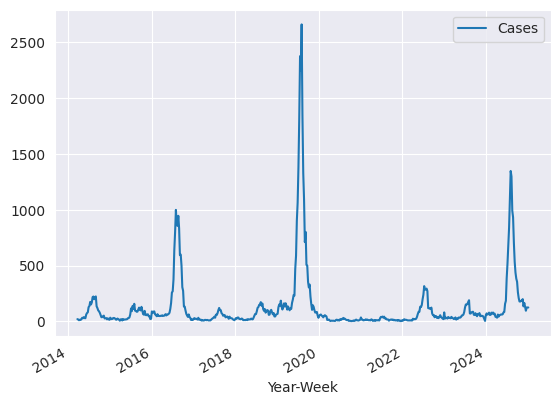

In [9]:
summed_df.plot(x="Year-Week", y="Cases", label="Cases")

In [12]:
predicted, MAE, MSE, feature_importance_dict = train_RF(summed_df, features_lag=["Temperature", "Precipitation", "Humidity"], features_addtl = ["Year", "Month", "Week", "Population"], target="Cases", date_col="Year-Week", n_ahead=12, year_test_start="2023-01-01", year_test_end="2024-12-31")

NameError: name 'train_RF' is not defined

In [13]:
plt.barh(feature_importance_dict.keys(), feature_importance_dict.values(), label="Feature Importance")

NameError: name 'feature_importance_dict' is not defined

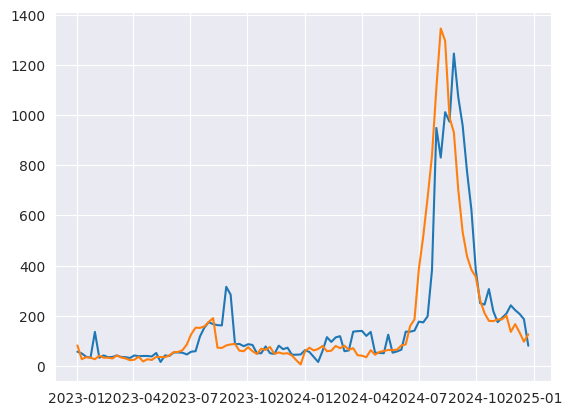

In [32]:
plt.plot(summed_df[(summed_df["Year-Week"].dt.year >= 2023) & (summed_df["Year-Week"].dt.year <= 2024)]["Year-Week"], predicted, label="Predicted")
plt.plot(summed_df[(summed_df["Year-Week"].dt.year >= 2023) & (summed_df["Year-Week"].dt.year <= 2024)]["Year-Week"], summed_df[(summed_df["Year-Week"].dt.year >= 2023) & (summed_df["Year-Week"].dt.year <= 2024)]["Cases"], label="Actual")

In [33]:
MAE

np.float64(69.59615384615384)

In [34]:
MSE

np.float64(17434.51923076923)

In [8]:
leave_one_season_out_df = pd.DataFrame(columns=["Municipal", "Year", "MAE", "MSE", "N_week_ahead"])

for i in range(1, 13):
    for municipal in municipals:
        municipal_df = pd.read_csv(f"../../data/Merged Data/{municipal}_merged.csv")
        municipal_df["Municipal"] = municipal
        # lag the features
        municipal_df = models_utils.prepare_dataframe(municipal_df, ["Temperature", "Precipitation", "Humidity"], ["Year", "Week", "Month", "Population"], "Cases", "Year-Week", i)
        for year in range(2014,2025):
            predictions, MAE, MSE, feat_imp = train_RF(municipal_df, features_lag=["Temperature", "Precipitation", "Humidity"], features_addtl = ["Year", "Month", "Week", "Population"], target="Cases", date_col="Year-Week", n_ahead=i, year_test_start=f"{year}-01-01", year_test_end=f"{year}-12-31")
            leave_one_season_out_df = pd.concat([leave_one_season_out_df, pd.DataFrame({"Municipal": [municipal], "Year": [year], "MAE": [MAE], "MSE": [MSE], "N_week_ahead": [i]})], axis=0)


In [10]:
leave_one_season_out_df.head()

,Municipal,Year,MAE,MSE,N_week_ahead
0,Ajuy,2014,0.862069,1.482759,1
0,Ajuy,2015,0.884615,1.153846,1
0,Ajuy,2016,1.846154,8.307692,1
0,Ajuy,2017,0.884615,1.115385,1
0,Ajuy,2018,1.615385,5.730769,1


In [11]:
# save leave_one_season_out_df to csv
leave_one_season_out_df.to_csv("leave_one_season_out_evaluation.csv", index=False)